# 509 Final Project

## Rsolve dependencies

In [1]:
! pip install newsapi-python

## Globally import libraries

In [227]:
#! pip install pyLDavis

import pyLDAvis

pyLDAvis.enable_notebook()
from tqdm.auto import tqdm

import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import numpy as np
import pandas as pd
import pymysql as mysql
import matplotlib.pyplot as plt
import os
import shutil
import re
import logging
import time
import zipfile
import requests
from bs4 import BeautifulSoup
import datetime
import re
import regex as rex
from collections import defaultdict, Counter
import random
import requests
from bs4 import BeautifulSoup
import datetime
import json
from wordcloud import WordCloud 
from tabulate import tabulate


import sqlite3
import nltk
from string import punctuation
from nltk.corpus import stopwords
import re
import emoji
from nltk.metrics import ConfusionMatrix
import itertools
import collections

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.decomposition import LatentDirichletAllocation

#import mysql.connector

# Set pandas global options
pd.options.display.max_rows = 17

## Functions:

### Data pre-processing:

In [169]:
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}


# Stopwords - added the 'nan' to this to remove nulls:
# next step could be to add pronouns like she/her, he/him, etc.

sw = stopwords.words("english")
sw = sw + ['nan']
sw = sw + ['said'] + ['news'] + ['us'] + ['reuters']

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

def remove_stop(tokens) :
    # modify this function to remove stopwords

    return[t for t in tokens if t not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return([item.lower() for item in whitespace_pattern.split(text)])
    
def remove_url(text):
    return(re.sub(r'http\S+', '', text))

def remove_messy(text): # remove words that give away the source
    text1=re.sub(r'cnn', '', text)
    text2=re.sub(r'fox', '', text1)
    text3=re.sub(r' — ', '', text2)
    text4=re.sub(r'breatbart', '', text3)
    return(re.sub(r'\\n', '', text4))

# two pipelines to either tokenize or simply remove punctuation
# and lowercase as we will need to extract feature words:

full_pipeline = [str.lower, remove_url, remove_messy, remove_punctuation, tokenize, remove_stop]
first_pipeline = [str.lower, remove_url, remove_messy, remove_punctuation]


def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

### Feature extraction Function:

In [5]:
def conv_features(text,fw) :
     feature_set=dict()
     for word in text.split():
          if word in fw:
               feature_set[word]=True
     return(feature_set)

### EDA functions:

Get Patterns, Counts, WordCloud:

In [6]:
def get_patterns(text_analyze, num_words, T):
    if(len(text_analyze)==0):
        raise ValueError("Can't work with empty text object")
    total_tokens = 1
    unique_tokens = 0
    avg_token_len = 0.0
    lexical_diversityP = 0.0
    top_words = []

    # Only applying the token_normal, which takes only alphanumeric values
    # to twitter data:
    if T ==1:
        text_analyze=token_normal(text_analyze)

    total_tokens = len(text_analyze)
    unique_tokens = len(set(text_analyze))
    lexical_diversityP = unique_tokens/total_tokens
    avg_token_len = np.mean([len(ta) for ta in text_analyze])

    top_words_1 = collections.Counter(text_analyze)
    top_words = top_words_1.most_common(num_words)

    results={'tokens': total_tokens,
             'unique_tokens': unique_tokens,
             'avg_token_length': avg_token_len,
             'lexical_diversity': lexical_diversityP,
             'top_words': top_words}
    return(results)

In [17]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
# Here, we only apply splitting to the lyrics data due to the difference
# in dataframe/data ingestion between twitter and lycis data:
    
#def count_words(df, column='tokens', preprocess=None, min_freq=2, split=0):
def count_words(x, preprocess=None, min_freq=2, split=0):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    #counter = collections.Counter()
    #top_words_1 = collections.Counter(text_analyze)
    #top_words = top_words_1.most_common(num_words)
    if split == 0:
        counter = collections.Counter(x)
    else: 
        counter = collections.Counter(x.split())

    #df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [26]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [2]:
today = datetime.date.today()
print(today)
print(type(today))

2023-06-03
<class 'datetime.date'>


## Connect to NewsAPI client

In [119]:
from newsapi import NewsApiClient

api_key = os.environ['NewsAPIKey']

# Init
newsapi = NewsApiClient(api_key=api_key)

## Pull article info from API

### /v2/top-headlines/sources
sources = newsapi.get_sources()
print(sources)

In [120]:
def news_api_urls(q=None,
                  s=None,
                  d_from='2023-05-01',
                  d_to='2023-05-31',
                  api_lst=[]):
    all_articles = newsapi.get_everything(q=q,
                                          sources=s,
                                          from_param=d_from,
                                          to=d_to,
                                          language='en',
                                          sort_by='relevancy',
                                          page=1)

    print(type(all_articles))
    print(all_articles)
    #print('Article list: ', all_articles['articles'])
    for article in all_articles['articles']:
        print('Source ID:', article['source']['id'])
        print('Source name:', article['source']['name'])
        print('Author:', article['author'])
        print('Title:', article['title'])
        print('URL:', article['url'])
        print('Publish date:', article['publishedAt'])
        print('Article text:', article['content'], '\n')

    # Create a list of tuples from the dictionary data
    source_data01 = [(a['source']['name'],
                      a['author'],
                      a['title'],
                      a['url'],
                      a['publishedAt'],
                      a['content'])
                     for a in all_articles['articles']]

    api_lst.extend(source_data01)
    #print(api_lst)
    print(len(api_lst))

## Data Collection:

### Connect to API to access URLs

#### Set API filter parameters

**Extract Training Data for Classifier**

Two Left leaning and Two Right leaning news sources are queried, collected, cleaned, and prepared for model training and test

In [ ]:
# Parameters to extract API News data from 4 sources:

source_lst = ['the-washington-post','cnn','fox-news','breitbart-news']


date_lst = ['2023-05-18', '2023-05-19', '2023-05-21', '2023-05-22', '2023-05-23'] 


q_word_lst = ['justice OR surveillance', 'healthcare OR "health care"',
              '(political AND (bias OR party)) OR republican OR democrat OR election',
              'security AND (social OR national)', '(policy AND (drug OR "affirmative action")) OR regulate OR regulation']



**Extract Client Data for Business Application of our Classifer**

Data from what is considered a Centered news source is extracted, preprocessed, and prepared to run through our trained Classifier. We report back the data gathered, the overall lean found in that data, and give details on the lean, if a political lean is found in the data.

In [167]:
# Parameters to extract API News data from 1 centered source:

source_lst = ['reuters']


date_lst = ['2023-05-18', '2023-05-19', '2023-05-20', '2023-05-21', '2023-05-22', '2023-05-23',
            '2023-05-24', '2023-05-25', '2023-05-17', '2023-05-16', '2023-05-15', '2023-05-14',
            '2023-05-26', '2023-05-27', '2023-05-28', '2023-05-29', '2023-05-30', '2023-05-31']

q_word_lst = ['justice OR surveillance', 'healthcare OR "health care"',
              '(political AND (bias OR party)) OR republican OR democrat OR election',
              'security AND (social OR national)', '(policy AND (drug OR "affirmative action")) OR regulate OR regulation']



#### Access API (collect URLs)

Using the defined parameters above, extract URL and other data information from the desired news sources.

In [168]:
api_record_lst01 = []
for s in source_lst:
    print(f'Source: {s}')
    for d in date_lst:
        print(f'Date: {d}')
        for q in q_word_lst:
            print(f'Query word: {q}')
            time.sleep(5 + 11 * random.random())
            news_api_urls(q=q,
                          s=s,
                          d_from=d,
                          d_to=d,
                          api_lst=api_record_lst01)
            print(s, d, q)
    time.sleep(10 + 13 * random.random())

print(api_record_lst01)
print(len(api_record_lst01))

Source: reuters
Date: 2023-05-18
Query word: justice OR surveillance
<class 'dict'>
{'status': 'ok', 'totalResults': 1, 'articles': [{'source': {'id': 'reuters', 'name': 'Reuters'}, 'author': None, 'title': 'Montana becomes first US state to ban TikTok', 'description': 'Montana Governor Greg Gianforte on Wednesday signed legislation to ban Chinese-owned TikTok from operating in the state to protect residents from alleged intelligence gathering by China, making it the first U.S. state to ban the popular short video app.', 'url': 'https://www.reuters.com/world/us/montana-governor-signs-bill-banning-tiktok-state-2023-05-17/', 'urlToImage': 'https://www.reuters.com/resizer/dd_pJvf_o8_qXsHpxJGFP37AaKU=/1200x628/smart/filters:quality(80)/cloudfront-us-east-2.images.arcpublishing.com/reuters/2KLX6QLKXNJSTKILQ2JHYYKZZU.jpg', 'publishedAt': '2023-05-18T13:42:12Z', 'content': 'WASHINGTON, May 17 (Reuters) - Montana Governor Greg Gianforte on Wednesday signed legislation to ban Chinese-owned TikT

#### Save into DataFrames:

Four sources data:

In [403]:
api_record_df2 = pd.DataFrame (list (api_record_lst01),
                                   columns = ['Source','Author','Title','URL','date','content'])

Centered Client data:

In [170]:
api_record_df = pd.DataFrame (list (api_record_lst01),
                                   columns = ['Source','Author','Title','URL','date','content'])
api_record_df.to_csv("News_API_Reuters2.csv", sep=',')

#### Code to combine different dataframes for training: (no need to run again)

In [405]:
api_record_df_final = pd.concat([api_record_df2, api_record_df])


In [ ]:
api_record_df_final.to_csv("News_API_FOX_CNN_Breitbert_May18_23_May31.csv", sep=',')
api_record_df.to_csv("News_API_FOX_CNN_Breitbert_May20_May31.csv", sep=',')
api_record_df2.to_csv("News_API_FOX_CNN_Breitbert_May1819_May2123.csv", sep=',')

In [415]:
api_record_df_filtered = api_record_df[api_record_df.Source != 'The Washington Post']

In [4]:
api_data_df3=pd.read_csv('News_API_FOX_CNN_Breitbert_May18_23_May31_2.csv')


In [5]:
api_record_df_final3 = api_data_df3[api_data_df3.Source != 'The Washington Post']

In [6]:
api_record_df_final3.to_csv("News_API_FOX_CNN_Breitbert_May18_23_May31_3.csv", sep=',')
api_record_df_final3.shape
api_record_df_filtered
api_record_df2.shape

In [419]:
api_record_df_final2 = pd.concat([api_record_df2, api_record_df_filtered])
api_record_df_final2.shape

In [421]:
api_record_df_final2.to_csv("News_API_FOX_CNN_Breitbert_May18_23_May31_2.csv", sep=',')
api_data_df_final3=pd.read_csv('News_API_FOX_CNN_Breitbert_May18_23_May31_2.csv')



### HTML scrape of URLs (to collect Article content)

#### FOX, CNN, Breitbert:

In [ ]:
slct_tbl_full_df02 = api_record_df_final3.copy()



slct_tbl_full_df02['article_parsed'] = ''

total_urls = len(slct_tbl_full_df02)

# Start timer
start_time = datetime.date.today()


for i, row in enumerate(slct_tbl_full_df02.itertuples(), 1):
    print(row[5])
    article=[]
    #url = slct_tbl_full_df02.at[i,'URL']
    url=row[5]
    response = requests.get(url)
    time.sleep(5 + 10*random.random())

    soup = BeautifulSoup(response.text, 'html.parser')

    try:
        script_tag = soup.find('script', {'type': 'application/ld+json'})
        if script_tag == None:
            print('\nJSON Object == None: Index:', i-1, '; source:',
                  row[2],
                  '; URL:', row[5]) 
        else:
            article_json = json.loads(script_tag.string)
            article_content = article_json['articleBody']
            slct_tbl_full_df02.at[row.Index, 'article_parsed'] = article_content

    except KeyError:
        print('\nMissing JSON key: Index:', i-1, '; source:',
              row[2],
              '; URL:', row[5]) 
        article_body = soup.find('div', class_='article__content-container') 

        if article_body is None: #forfoxandbreitbert(sometimes)
            print('Class != article__content-container')
            article_body = soup.find('p', class_="speakable")
            if article_body is None: #breitbert(most)
                print('Class != speakable')
                article_body = soup.find('div', class_='entry-content')
                if article_body is None: #WashPost
                    print('Class != entry-content')
                    article_body = soup.find('div',class_='article-body')

        if article_body is not None:
            article_text = article_body.get_text()
            slct_tbl_full_df02.at[row.Index, 'article_parsed'] = article_text
        else:
            print('Could not parse')

    print('.', end='')
        
# End timer script
end_time = datetime.date.today()
time_elapse = end_time - start_time
print(f'Start Time = {start_time}')
print(f'End Time = {end_time}')
print(f'Elapsed Time = {time_elapse}')

In [ ]:
slct_tbl_full_df02.to_csv("News_API_FOX_CNN_Breitbert_May18_23_May31_3.csv", sep=',')

#### Reuters:

In [174]:
slct_tbl_full_df02 = api_record_df.copy()


slct_tbl_full_df02['article_parsed'] = ''

total_urls = len(slct_tbl_full_df02)

# Start timer
start_time = datetime.date.today()


for i, row in enumerate(slct_tbl_full_df02.itertuples(), 1):
    print(row[4])
    article=[]
    #url = slct_tbl_full_df02.at[i,'URL']
    url=row[4]
    response = requests.get(url)
    time.sleep(5 + 10*random.random())

    soup = BeautifulSoup(response.text, 'html.parser')

    try:
        script_tag = soup.find('script', {'type': 'application/ld+json'})
        if script_tag == None:
            print('\nJSON Object == None: Index:', i-1, '; source:',
                  row[1],
                  '; URL:', row[4]) 
        else:
            article_json = json.loads(script_tag.string)
            article_content = article_json['articleBody']
            slct_tbl_full_df02.at[row.Index, 'article_parsed'] = article_content

    except KeyError:
        print('\nMissing JSON key: Index:', i-1, '; source:',
              row[1],
              '; URL:', row[4]) 
        article_body = soup.find('div', class_='article__content__6hMn9') #Reuters scrape attempt

        if article_body is None: #forfoxandbreitbert(sometimes)
            print('Class != article__content-container')
            article_body = soup.find('p', class_="speakable")
            if article_body is None: #breitbert(most)
                print('Class != speakable')
                article_body = soup.find('div', class_='entry-content')
                if article_body is None: #WashPost
                    print('Class != entry-content')
                    article_body = soup.find('div',class_='article-body')

        if article_body is not None:
            article_text = article_body.get_text()
            slct_tbl_full_df02.at[row.Index, 'article_parsed'] = article_text
        else:
            print('Could not parse')

    print('.', end='')
        
# End timer script
end_time = datetime.date.today()
time_elapse = end_time - start_time
print(f'Start Time = {start_time}')
print(f'End Time = {end_time}')
print(f'Elapsed Time = {time_elapse}')

https://www.reuters.com/world/us/montana-governor-signs-bill-banning-tiktok-state-2023-05-17/

Missing JSON key: Index: 0 ; source: Reuters ; URL: https://www.reuters.com/world/us/montana-governor-signs-bill-banning-tiktok-state-2023-05-17/
.https://www.reuters.com/business/billionaire-real-estate-investor-sam-zell-dies-2023-05-18/

Missing JSON key: Index: 1 ; source: Reuters ; URL: https://www.reuters.com/business/billionaire-real-estate-investor-sam-zell-dies-2023-05-18/
.https://www.reuters.com/world/us/montana-governor-signs-bill-banning-tiktok-state-2023-05-17/

Missing JSON key: Index: 2 ; source: Reuters ; URL: https://www.reuters.com/world/us/montana-governor-signs-bill-banning-tiktok-state-2023-05-17/
.https://www.reuters.com/business/disney-close-star-wars-hotel-that-opened-florida-last-year-2023-05-18/

Missing JSON key: Index: 3 ; source: Reuters ; URL: https://www.reuters.com/business/disney-close-star-wars-hotel-that-opened-florida-last-year-2023-05-18/
.https://www.reut

#### Check Data:

In [25]:
slct_tbl_full_df02.isnull().sum()

Unnamed: 0        0
Source            0
Author            0
Title             0
URL               0
date              0
content           0
article_parsed    0
dtype: int64

In [175]:
api_record_df_latest=slct_tbl_full_df02.copy()

Make sure Word count for parsed article is correct:

In [176]:
api_record_df_latest['word_count'] = api_record_df_latest['article_parsed'].apply(lambda x: len(str(x).split(" ")))

Only include rows with a word_count greater than 1:

In [ ]:
api_record_df_latest = api_record_df_latest[api_record_df_latest['word_count']>1]

Save Data to CSV:

In [177]:
api_record_df_latest.to_csv("News_API_Susy_word_count2.csv", sep=',')


In [178]:
api_record_df_latest.tail(100)

,Source,Author,Title,URL,date,content,article_parsed,word_count
0,Reuters,None,Montana becomes first US state to ban TikTok,https://www.reuters.com/world/us/montana-gover...,2023-05-18T13:42:12Z,"WASHINGTON, May 17 (Reuters) - Montana Governo...",United StatesMontana to become first US state ...,727
1,Reuters,Reuters,Billionaire real estate investor Sam Zell dies...,https://www.reuters.com/business/billionaire-r...,2023-05-18T15:23:08Z,"May 18 (Reuters) - Billionaire Sam Zell, who b...","BusinessSam Zell, billionaire real estate inve...",368
2,Reuters,None,Montana becomes first US state to ban TikTok,https://www.reuters.com/world/us/montana-gover...,2023-05-18T13:42:12Z,"WASHINGTON, May 17 (Reuters) - Montana Governo...",United StatesMontana to become first US state ...,727
3,Reuters,Lisa Richwine,Disney to close Star Wars hotel that opened in...,https://www.reuters.com/business/disney-close-...,2023-05-18T22:09:31Z,"LOS ANGELES, May 18 (Reuters) - Walt Disney Co...",BusinessDisney to close Star Wars hotel that o...,312
4,Reuters,Dawn Chmielewski,"Disney cancels plans to relocate 2,000 jobs to...",https://www.reuters.com/business/media-telecom...,2023-05-18T18:26:03Z,"LOS ANGELES, May 18 (Reuters) - Walt Disney Co...",World at WorkDisney cancels plans for $1 billi...,703
...,...,...,...,...,...,...,...,...
44,Reuters,Towleroad,Blinken says US to consider visa restrictions ...,http://rmb.reuters.com/rmd/rss/item/tag:reuter...,2023-05-30T17:13:45Z,WASHINGTON (Reuters) – U.S. Secretary of State...,,1
45,Reuters,Towleroad,Deepfaking it: America’s 2024 election collide...,http://rmb.reuters.com/rmd/rss/item/tag:reuter...,2023-05-30T17:12:23Z,(Note: Strong language in paragraph 10)\r\nBy ...,,1
46,Reuters,Towleroad,Trump captured on tape acknowledging he kept a...,http://rmb.reuters.com/rmd/rss/item/tag:reuter...,2023-05-31T22:57:34Z,WASHINGTON (Reuters) – Federal prosecutors hav...,,1
47,Reuters,Towleroad,Trump captured on tape acknowledging he kept a...,http://rmb.reuters.com/rmd/rss/item/tag:reuter...,2023-05-31T22:57:34Z,WASHINGTON (Reuters) – Federal prosecutors hav...,,1


#### Old article parsed method (mine)

In [308]:
article=[]

for index, rows in api_record_df.iterrows():
    article=[]
    url = api_record_df.at[index,'URL']
    response = requests.get(url)
    time.sleep(5 + 10*random.random())

    soup = BeautifulSoup(response.text, 'html.parser')
    #forcnn
    article_body = soup.find('div', class_='article__content-container')
    
    if article_body is None: #forfoxandbreitbert(sometimes)
        article_body = soup.find('p', class_="speakable")
        if article_body is None: #breitbert(most)
            article_body = soup.find('div', class_='entry-content')
            if article_body is None: #WashPost
                article_body = soup.find('div',class_='article-body')
                #if article_body is None:
                #    break
                                         

    if article_body is not None:
        article_text = article_body.get_text()
        api_record_df.at[index,'full_text']=article_text



In [309]:
api_record_df['Source'].value_counts()

Fox News               84
Breitbart News         53
CNN                    37
The Washington Post    25
Name: Source, dtype: int64

In [310]:
api_record_df.isnull().sum()

Source       0
Author       2
Title        0
URL          0
date         0
content      0
full_text    2
dtype: int64

Save dataframe to csv file:

In [336]:
#api_record_df.to_csv("News_API_FOX_CNN_Breitbert_WAPOST_allcolumns.csv", sep=',')

In [ ]:
api_record_df.to_csv("News_API_FOX_CNN_Breitbert_WAPOST_allcolumns.csv", sep=',')

In [138]:
api_record_df_latest.to_csv("Reuters_article.csv", sep=',')

In [10]:
#api_record_lst01 = [(1, 1, 1), (2, 2, 2), (3, 3, 3), (1, 1, 1), (4, 4, 4), (3, 3, 3)]
#print(api_record_lst01)
api_record_set01 = set(api_record_lst01)
print(api_record_set01)
api_record_lst02 = list(api_record_set01)
print(api_record_lst02)
print(len(api_record_lst02))

{('Fox News', 'Lawrence Richard', "Texas legislature's first special session focusing on border security, cutting property taxes, Abbott reveals", 'https://www.foxnews.com/politics/texas-legislatures-first-special-session-focusing-border-security-cutting-property-taxes-abbott-reveals', '2023-05-30T06:00:33Z', "Texas Gov. Greg Abbott revealed agenda items for the state legislature's first special session late Monday evening a list that includes cutting property taxes and providing funds to secure the U.S.-M… [+2386 chars]"), ('Fox News', 'Paul Steinhauser', 'Potential 2024 Republican presidential contender moves a step closer to launching a campaign', 'https://www.foxnews.com/politics/potential-2024-republican-presidential-contender-moves-step-closer-launching-campaign', '2023-05-30T15:25:48Z', 'Long-time supporters and allies of former New Jersey Gov. Chris Christie are launching a super PAC to back his likely campaign for the 2024 Republican presidential nomination, Fox News has confi

### Load Data from DataFrames:

**Full Dataset compiled for Training/Test of Classifier**

In [2]:
api_data_complete_df=pd.read_csv('../data/master.csv')


**Client Dataset to collect Classifier Results for Client**

In [194]:
api_data_complete_df=pd.read_csv('News_API_Susy_word_count2.csv')
api_data_complete_df.rename (columns = {'article_parsed':'article_text'}, inplace=True) 


In [216]:
#api_data_complete_df['Author'].value_counts()

In [215]:
#api_data_complete_df.head()

## Pre-Process Data:

In [181]:
# Tokenize text:

api_data_complete_df['tokens']= api_data_complete_df['article_text'].apply(prepare,
                                                     pipeline=full_pipeline)

In [199]:
# Clean data into lowercase/no punctuation:

api_data_complete_df['cleaner_text']= api_data_complete_df['article_text'].apply(prepare,
                                                     pipeline=first_pipeline)

In [9]:
# Add target variable values:

api_data_complete_df['Political_Lean'] = np.where((api_data_complete_df['source_name'] == "CNN") | (api_data_complete_df['source_name'] == "The Washington Post"), 'Left', 'Right')

In [168]:
#api_data_complete_df2.to_csv("master_tokenized_noReutersAPMSN.csv", sep=',')

----------

## EDA

### Word Counts:

In [363]:
#api_data_df=pd.read_csv('News_API_FOX_CNN_Breitbert_WAPOST_allcolumns.csv')

In [183]:
api_data_complete_df['word_count_tokens'] = api_data_complete_df['tokens'].apply(lambda x: len(str(x).split(" ")))
api_data_complete_df['word_count'] = api_data_complete_df['article_text'].apply(lambda x: len(str(x).split(" ")))

In [184]:
api_data_complete_df['word_count_cleaner'] = api_data_complete_df['cleaner_text'].apply(lambda x: len(str(x).split(" ")))

In [200]:
# Centered data:

api_data_complete_df23 = api_data_complete_df[api_data_complete_df['word_count']>1]


In [205]:
api_data_complete_df23.head()

,Unnamed: 0,Source,Author,Title,URL,date,content,article_text,word_count,cleaner_text
0,0,Reuters,NaN,Montana becomes first US state to ban TikTok,https://www.reuters.com/world/us/montana-gover...,2023-05-18T13:42:12Z,"WASHINGTON, May 17 (Reuters) - Montana Governo...",United StatesMontana to become first US state ...,727,united statesmontana to become first us state ...
1,1,Reuters,Reuters,Billionaire real estate investor Sam Zell dies...,https://www.reuters.com/business/billionaire-r...,2023-05-18T15:23:08Z,"May 18 (Reuters) - Billionaire Sam Zell, who b...","BusinessSam Zell, billionaire real estate inve...",368,businesssam zell billionaire real estate inves...
2,2,Reuters,NaN,Montana becomes first US state to ban TikTok,https://www.reuters.com/world/us/montana-gover...,2023-05-18T13:42:12Z,"WASHINGTON, May 17 (Reuters) - Montana Governo...",United StatesMontana to become first US state ...,727,united statesmontana to become first us state ...
3,3,Reuters,Lisa Richwine,Disney to close Star Wars hotel that opened in...,https://www.reuters.com/business/disney-close-...,2023-05-18T22:09:31Z,"LOS ANGELES, May 18 (Reuters) - Walt Disney Co...",BusinessDisney to close Star Wars hotel that o...,312,businessdisney to close star wars hotel that o...
4,4,Reuters,Dawn Chmielewski,"Disney cancels plans to relocate 2,000 jobs to...",https://www.reuters.com/business/media-telecom...,2023-05-18T18:26:03Z,"LOS ANGELES, May 18 (Reuters) - Walt Disney Co...",World at WorkDisney cancels plans for $1 billi...,703,world at workdisney cancels plans for 1 billio...


### Remove "centered" authors from Training/Test Data:

In [12]:
# Removing Reuters, ms, and Associated Press authors from data:

api_data_complete_df2 = api_data_complete_df[~api_data_complete_df['author'].isin(['msn', 'Associated Press', 'Reuters'])]

display(api_data_complete_df2.head())

display(api_data_complete_df2['Political_Lean'].value_counts())

,source_name,author,title,url,publish_date,content,article_text,tokens,cleaner_text,Political_Lean,word_count_tokens,word_count,word_count_cleaner
0,The Washington Post,NaN,Alabama Highway sign hacked with white suprema...,https://www.washingtonpost.com/nation/2023/05/...,2023-05-30T16:31:36Z,Travelers in Alabama driving on Interstate 65 ...,Travelers in Alabama driving on Interstate 65 ...,"[travelers, alabama, driving, interstate, 65, ...",travelers in alabama driving on interstate 65 ...,Left,558,923,921
1,The Washington Post,Amber Phillips,Breaking down the GOP investigation into the B...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T19:56:33Z,Comment on this story\r\nComment\r\nA federal ...,A federal prosecutor may be nearing a decision...,"[federal, prosecutor, may, nearing, decision, ...",a federal prosecutor may be nearing a decision...,Left,632,1089,1077
2,The Washington Post,David Ovalle,Appeals court paves way for Purdue Pharma opio...,https://www.washingtonpost.com/health/2023/05/...,2023-05-30T23:52:34Z,Comment on this story\r\nComment\r\nA federal ...,A federal appeals court Tuesday cleared the wa...,"[federal, appeals, court, tuesday, cleared, wa...",a federal appeals court tuesday cleared the wa...,Left,506,869,853
3,The Washington Post,Philip Bump,Trump pledges to win an immigration fight he d...,https://www.washingtonpost.com/politics/2023/0...,2023-05-30T18:30:47Z,Comment on this story\r\nComment\r\nSpeaking i...,"Speaking in Orlando in November 2015, Republic...","[speaking, orlando, november, 2015, republican...",speaking in orlando in november 2015 republica...,Left,522,956,944
4,The Washington Post,NaN,The revolt of Christian home-schoolers...,https://www.washingtonpost.com/education/inter...,2023-05-30T18:25:37Z,Deep Reads features The Washington Posts best ...,NaN,[],nan,Left,1,1,1


Political_Lean
Right    2758
Left     1269
Name: count, dtype: int64

### Word Clouds

In [13]:
# Separate Left and Right Lean articles to analyze as groups:

Left_lean_articles_df=api_data_complete_df2[api_data_complete_df2['Political_Lean']=="Left"]
Right_lean_articles_df=api_data_complete_df2[api_data_complete_df2['Political_Lean']=="Right"]



In [14]:
# Generate list from Left an Right dataframes:

Left_text=[token for sublist in
           Left_lean_articles_df['tokens'] 
           for token in sublist]
Right_text=[token for sublist in 
            Right_lean_articles_df['tokens']
            for token in sublist]


In [195]:
#Left_text

In [15]:
# Left lean vs Right lean word clouds:

Left_Lean_counts = collections.Counter(Left_text)


Right_Lean_counts = collections.Counter(Right_text)



print("\nLeft Leaning Article's top 5 words:\n")
for HT, count in Left_Lean_counts.most_common(5):
    print(f"{HT}: {count}")

print("\nRight Leaning Article's top 5 words:\n")
for HT, count in Right_Lean_counts.most_common(5):
    print(f"{HT}: {count}")


Left Leaning Article's top 5 words:

would: 3591
trump: 3442
also: 2774
house: 2566
people: 2507

Right Leaning Article's top 5 words:

biden: 4453
president: 3767
also: 3621
would: 3512
people: 3375


In [18]:
Left_Lean_counts = count_words(Left_text, split=0)
Right_Lean_counts = count_words(Right_text, split=0)
display(Left_Lean_counts)

,freq
token,
would,3591
trump,3442
also,2774
house,2566
people,2507
...,...
paints,2
houghton,2
912,2


In [ ]:
#her_df=lyrics_data_df.loc[0,:]
#robyn_df=lyrics_data_df.loc[1,:]

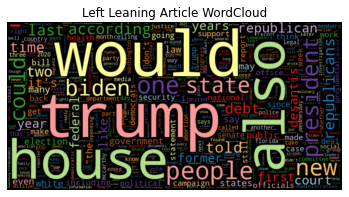

In [19]:
wordcloud(Left_Lean_counts['freq'], title="Left Leaning Article WordCloud", max_words=500)

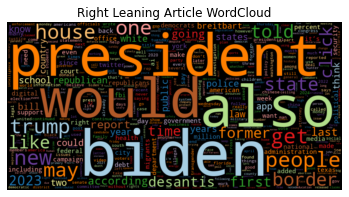

In [20]:
wordcloud(Right_Lean_counts['freq'], title="Right Leaning Article WordCloud", max_words=500)

### Topic Modeling Right vs Left:

In [39]:
Left_tfidf_topic = TfidfVectorizer(stop_words=list(sw), min_df=5, max_df=0.7, ngram_range=(1,2))
Left_topic_modeling_input = Left_tfidf_topic.fit_transform(Left_lean_articles_df['cleaner_text'])

In [40]:
Right_tfidf_topic = TfidfVectorizer(stop_words=list(sw), min_df=5, max_df=0.7, ngram_range=(1,2))
Right_topic_modeling_input = Right_tfidf_topic.fit_transform(Right_lean_articles_df['cleaner_text'])

In [49]:
nmf_text_model_newsL = NMF(n_components=3, random_state=314)
Left_text_matrix = nmf_text_model_newsL.fit_transform(Left_topic_modeling_input)
HLeft_text_matrix = nmf_text_model_newsL.components_

In [50]:
nmf_text_model_newsR = NMF(n_components=3, random_state=314)
Right_text_matrix = nmf_text_model_newsR.fit_transform(Right_topic_modeling_input)
HRight_text_matrix = nmf_text_model_newsR.components_

Display Topics for Left vs Right:

In [51]:
display_topics(nmf_text_model_newsL, Left_tfidf_topic.get_feature_names_out())


Topic 00
  trump (1.75)
  desantis (1.14)
  president (0.32)
  campaign (0.32)
  former (0.31)

Topic 01
  debt (0.97)
  house (0.63)
  mccarthy (0.61)
  biden (0.60)
  debt ceiling (0.57)

Topic 02
  court (0.21)
  state (0.21)
  police (0.15)
  people (0.15)
  abortion (0.14)


In [52]:
display_topics(nmf_text_model_newsR, Right_tfidf_topic.get_feature_names_out())


Topic 00
  biden (0.22)
  debt (0.17)
  house (0.16)
  ai (0.14)
  bill (0.13)

Topic 01
  border (1.72)
  migrants (1.12)
  title (0.71)
  title 42 (0.65)
  42 (0.64)

Topic 02
  desantis (1.29)
  trump (1.24)
  percent (0.59)
  president (0.41)
  florida (0.39)


### LDA topic modeling for visualization:

In [77]:
Lcount_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=5, max_df=0.7)
Left_count_text_vectors = Lcount_text_vectorizer.fit_transform(Left_lean_articles_df['cleaner_text'])
Left_count_text_vectors.shape

Rcount_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=5, max_df=0.7)
Right_count_text_vectors = Rcount_text_vectorizer.fit_transform(Right_lean_articles_df['cleaner_text'])
Right_count_text_vectors.shape

(2758, 13927)

In [217]:


Left_lda_para_model = LatentDirichletAllocation(n_components = 4, random_state=42)
W_lda_para_matrix_Left = Left_lda_para_model.fit_transform(Left_count_text_vectors)
H_lda_para_matrix_Left = Left_lda_para_model.components_

In [218]:
Right_lda_para_model = LatentDirichletAllocation(n_components = 4, random_state=42)
W_lda_para_matrix_Right = Right_lda_para_model.fit_transform(Right_count_text_vectors)
H_lda_para_matrix_Right = Right_lda_para_model.components_

In [219]:
display_topics(Left_lda_para_model, Lcount_text_vectorizer.get_feature_names_out())



Topic 00
  people (0.77)
  health (0.58)
  state (0.57)
  new (0.48)
  year (0.42)

Topic 01
  house (1.17)
  biden (1.06)
  debt (1.04)
  could (0.60)
  mccarthy (0.57)

Topic 02
  trump (2.13)
  desantis (0.78)
  president (0.76)
  election (0.63)
  state (0.58)

Topic 03
  court (0.62)
  people (0.45)
  police (0.39)
  according (0.37)
  new (0.33)


In [220]:
display_topics(Right_lda_para_model, Rcount_text_vectorizer.get_feature_names_out())



Topic 00
  also (0.44)
  people (0.44)
  would (0.42)
  one (0.39)
  school (0.37)

Topic 01
  trump (1.18)
  president (0.98)
  biden (0.80)
  desantis (0.71)
  former (0.51)

Topic 02
  police (0.79)
  biden (0.46)
  told (0.45)
  fbi (0.45)
  according (0.42)

Topic 03
  border (1.66)
  migrants (0.96)
  biden (0.92)
  texas (0.62)
  administration (0.62)


In [221]:
lda_display_left = pyLDAvis.lda_model.prepare(Left_lda_para_model, Left_count_text_vectors, Lcount_text_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display_left)

In [222]:
lda_display_right = pyLDAvis.lda_model.prepare(Right_lda_para_model, Right_count_text_vectors, Rcount_text_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display_right)

Only one missing value for relevant article text:

In [223]:
#api_data_complete_df2.isna().sum()

----------------


## Modeling:

In [44]:
# Obtain total counts of words in the entire corpus:

word_dist=Counter([item for sublist in api_data_complete_df['tokens'] 
                   for item in sublist])

### Prepare data for modeling (Target defined, clean text as X)

In [46]:
# generate the dict data to then be filtered through
# the filtered_words list:

news_data=dict()

    
news_data=[(api_data_complete_df.at[index,'cleaner_text'],
            api_data_complete_df.at[index,'Political_Lean']) for (index,row) in api_data_complete_df.iterrows()]

### Feature Words filtering:

In [47]:
word_cutoff=5
feature_words2=[]
for word, count in word_dist.items() :
    #for convention_data_df['word_dist']
    if count > word_cutoff :
        feature_words2.append(word)
            
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words2)} as features in the model.")

With a word cutoff of 5, we have 22181 as features in the model.


In [155]:
#feature_words2

In [324]:
# remove cnn and fox-news from the key featurewords:

#feature_words2.remove("cnn")
#feature_words2.remove("fox")
#feature_words2.remove("wpost")
#feature_words2.remove("breitbart")


In [48]:
# Filter the data through the feature words set
# determined above:

featuresets=dict()
featuresets = [(conv_features(text,feature_words2), 
                lean) for (text, lean) in news_data]

In [156]:
#featuresets

In [ ]:
#api_record_df['full_text']

### Rough Naive-Bayes Classifier setup and run-through:

In [49]:
random.seed(42)
random.shuffle(featuresets)
test_size = 20


In [50]:
test_set=dict()
train_set=dict()
test_set, train_set = featuresets[:test_size], featuresets[test_size:]

In [51]:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.2


In [52]:
# Confusion Matrix:

predicted_labels = [classifier.classify(features) for features, 
                    label in test_set]
gold_labels = [label for features, label in test_set]

cm = ConfusionMatrix(gold_labels, predicted_labels)
print(cm.pretty_format(sort_by_count=True, show_percents=True))

      |      R        |
      |      i      L |
      |      g      e |
      |      h      f |
      |      t      t |
------+---------------+
Right |     <.> 80.0% |
 Left |      . <20.0%>|
------+---------------+
(row = reference; col = test)



### Linear SVC (SVM) implementation:

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(api_data_complete_df2['cleaner_text'],
                                                    api_data_complete_df2['Political_Lean'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=api_data_complete_df2['Political_Lean'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  3221
Size of Test Data  806


In [56]:
# TF-IDF Vectorization for Training/Test Data:

tfidf = TfidfVectorizer(min_df = 10, max_df=0.7, ngram_range=(1,2), stop_words=sw)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [157]:
# Train Lineary SVC Model with Training Data:

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

In [66]:
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
#print ('F1 Score - ', recall_score(Y_test, Y_pred))

Accuracy Score -  0.9528535980148883


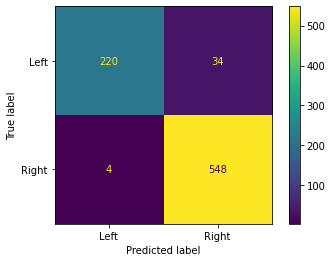

In [159]:
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model1.classes_)
disp.plot()
plt.show()

#### Test Results Linear SVC: 

In [225]:
TNmodel1=cm[0][0]
FPmodel1=cm[0][1]
FNmodel1=cm[1][0]
TPmodel1=cm[1][1]

In [228]:
# Results:

TANmodel1=TNmodel1+FPmodel1
TAPmodel1=TPmodel1+FNmodel1
TPPmodel1=FPmodel1+TPmodel1
TPNmodel1=TNmodel1+FNmodel1
GTmodel1=TANmodel1+TAPmodel1
AccuracyM1=(TNmodel1+TPmodel1)/GTmodel1
ErrorRateM1=1-AccuracyM1
SensitivityM1=TPmodel1/(TAPmodel1)
RecallM1=SensitivityM1
SpecificityM1=TNmodel1/TANmodel1
PrecisionM1=TPmodel1/TPPmodel1
F1M1=2*PrecisionM1*RecallM1/(PrecisionM1 + RecallM1)
F2M1=5*(PrecisionM1*RecallM1)/((4*PrecisionM1)+RecallM1)
Fp5M1=(1.25)*(PrecisionM1*RecallM1)/((0.25*PrecisionM1)+RecallM1)

header = ["Accuracy", "Error Rate", "Sensitivity", "Recall", "Specificity",
          "Precision", "F1", "F2", "F0.5"]
data1 = [["Accuracy", AccuracyM1], ["Error Rate", ErrorRateM1],
         ["Sensitivity", SensitivityM1],
         ["Recall", RecallM1], ["Specificity", SpecificityM1],
         ["Precision", PrecisionM1],
         ["F1", F1M1], ["F2", F2M1], ["F0.5", Fp5M1]]

col_names=["Measurement", "CART Model"]

ModelEvaluationTable = tabulate(data1, headers=col_names,
                                tablefmt="fancy_grid")

print(ModelEvaluationTable)

╒═══════════════╤══════════════╕
│ Measurement   │   CART Model │
╞═══════════════╪══════════════╡
│ Accuracy      │    0.952854  │
├───────────────┼──────────────┤
│ Error Rate    │    0.0471464 │
├───────────────┼──────────────┤
│ Sensitivity   │    0.992754  │
├───────────────┼──────────────┤
│ Recall        │    0.992754  │
├───────────────┼──────────────┤
│ Specificity   │    0.866142  │
├───────────────┼──────────────┤
│ Precision     │    0.941581  │
├───────────────┼──────────────┤
│ F1            │    0.96649   │
├───────────────┼──────────────┤
│ F2            │    0.982079  │
├───────────────┼──────────────┤
│ F0.5          │    0.951389  │
╘═══════════════╧══════════════╛


----

## Apply Classifier to Business Client Data:

In [ ]:
#Centered data Prep classification:

X_data = api_data_complete_df23['cleaner_text']

In [ ]:
# TF-IDF Vectorization for Business application:

X_Data_Centered = tfidf.transform(X_data)

### Linear SVD:

In [208]:
Data_Classification_Centered = model1.predict(X_Data_Centered)


In [213]:
print(api_data_complete_df23['Author'])

0                  NaN
1              Reuters
2                  NaN
3        Lisa Richwine
4     Dawn Chmielewski
            ...       
35                 NaN
39      Kirsty Needham
41        Florence Tan
42           Joyce Lee
48       Nichola Groom
Name: Author, Length: 23, dtype: object


In [209]:
Data_Classification_Centered

array(['Left', 'Left', 'Left', 'Right', 'Left', 'Left', 'Left', 'Left',
       'Left', 'Left', 'Left', 'Left', 'Right', 'Left', 'Right', 'Right',
       'Left', 'Right', 'Left', 'Right', 'Right', 'Left', 'Right'],
      dtype=object)

### SKLEARN SVC for probability testing:

In [210]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_tf, Y_train)

print(svm.predict_proba(X_Data_Centered))

[[0.82384571 0.17615429]
 [0.69748878 0.30251122]
 [0.82384571 0.17615429]
 [0.21148731 0.78851269]
 [0.7840795  0.2159205 ]
 [0.70713851 0.29286149]
 [0.70713851 0.29286149]
 [0.90912016 0.09087984]
 [0.69653185 0.30346815]
 [0.87517866 0.12482134]
 [0.87953816 0.12046184]
 [0.91090842 0.08909158]
 [0.07625658 0.92374342]
 [0.99040779 0.00959221]
 [0.00723159 0.99276841]
 [0.00723159 0.99276841]
 [0.91269056 0.08730944]
 [0.40496648 0.59503352]
 [0.88869085 0.11130915]
 [0.03909477 0.96090523]
 [0.74443724 0.25556276]
 [0.96795832 0.03204168]
 [0.43923826 0.56076174]]


----

## Initiate MySQL connection

In [14]:
'''Set local environment variables to hide user name & password citation:
https://www.geeksforgeeks.org/how-to-hide-sensitive-credentials-using-python/'''

user_name = "sqluser"
user_pass = "password"

#user_name = os.environ['MySQLUSRAC']
#user_pass = os.environ['MySQLPWDAC']

# Instantiate connection
db_conn = mysql.connect(host='localhost',
                        port=int(3306),
                        user=user_name,
                        passwd=user_pass,
                        db='509_final_proj')

# Create a cursor object
cursor = db_conn.cursor()

In [15]:
tbl_names = pd.read_sql('SHOW TABLES', db_conn)

display(tbl_names)
print(type(tbl_names))

c:\Users\Susy\anaconda3\envs\humans\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,Tables_in_509_final_proj


<class 'pandas.core.frame.DataFrame'>


### Establish logging policy

In [20]:
'''Logging citations (see additional code in following code blocks:
OpenAI. (2021). ChatGPT [Computer software]. https://openai.com/;
https://docs.python.org/3/howto/logging.html#logging-basic-example;
https://docs.python.org/3/howto/logging.html#logging-to-a-file;
https://docs.python.org/3/howto/logging-cookbook.html#using-a-rotating-log-file-handler;
https://docs.python.org/3/howto/logging-cookbook.html#using-a-timed-rotating-file-handler'''

# Set up logging
logging.basicConfig(level=logging.INFO,
                    filename='pymysql.log',
                    filemode='a',
                    format='>>>>>>>>>>>>>><<<<<<<<<<<<<<\n%(asctime)s - %(levelname)s - %(message)s')

### Update individual tables

#### Update `news_articles` table from API

In [21]:
nat_tbl_name = 'nar_temp'
nwa_tbl_name = 'news_articles'

In [22]:
'''Using cursor and loading into temp file:
OpenAI. (2021). ChatGPT [Computer software]. https://openai.com/;
https://pynative.com/python-mysql-insert-data-into-database-table/'''

# Execute query and measure execution time
start_time = time.time()

# Wipe temp table
try:
    nat_dlt_tble_stmnt = f"""DELETE FROM {nat_tbl_name}"""
    cursor.execute(nat_dlt_tble_stmnt)
    logging.info(f'Successfully executed query:\n{nat_dlt_tble_stmnt}\n\nRecords scanned: {cursor.rowcount}')
except mysql.Error as e:
    logging.error(f'Error executing query:\n{nat_dlt_tble_stmnt}\n\n{e}')
finally:
    end_time = time.time()
    logging.info(f'Time taken: {end_time - start_time:.3f} seconds\n>>>>>>>>>>>>>><<<<<<<<<<<<<<\n\n')

# Execute query and measure execution time
start_time = time.time()

# Load data from CSV file into a temporary table
try:
    nat_csv_load_stmnt = f"""
    INSERT INTO {nat_tbl_name}
    (
    source_name,
    author,
    title,
    url,
    publish_date,
    content
    )
    VALUES (%s, %s, %s, %s, %s, %s)
    """

    # Execute the query with multiple values
    cursor.executemany(nat_csv_load_stmnt, api_record_lst02)
    #cursor.execute(nat_csv_load_stmnt)
    logging.info(f'Successfully executed query:\n{nat_csv_load_stmnt}\n\nRecords scanned: {cursor.rowcount}')
except mysql.Error as e:
    logging.error(f'Error executing query:\n{nat_csv_load_stmnt}\n\n{e}')
finally:
    end_time = time.time()
    logging.info(f'Time taken: {end_time - start_time:.3f} seconds\n>>>>>>>>>>>>>><<<<<<<<<<<<<<\n\n')

# Execute query and measure execution time
start_time = time.time()

# Insert new records into main table
try:
    nwa_load_stmnt = f"""
    INSERT INTO {nwa_tbl_name}
    (
    source_name,
    author,
    title,
    url,
    publish_date,
    content
    )
    SELECT
        tp.source_name,
        tp.author,
        tp.title,
        tp.url,
        tp.publish_date,
        tp.content
    FROM {nat_tbl_name} AS tp
    LEFT JOIN {nwa_tbl_name} AS mn
        ON tp.title = mn.title
            AND CAST(LEFT(tp.publish_date, 10) AS DATE) = CAST(LEFT(mn.publish_date, 10) AS DATE)
            AND tp.author = mn.author
    """
    cursor.execute(nwa_load_stmnt)
    logging.info(f'Successfully executed query:\n{nwa_load_stmnt}\n\nRecords scanned: {cursor.rowcount}')
except mysql.Error as e:
    logging.error(f'Error executing query:\n{nwa_load_stmnt}\n\n{e}')
finally:
    end_time = time.time()
    logging.info(f'Time taken: {end_time - start_time:.3f} seconds\n>>>>>>>>>>>>>><<<<<<<<<<<<<<\n\n')

# Execute query and measure execution time
start_time = time.time()

# Wipe temp table
try:
    cursor.execute(nat_dlt_tble_stmnt)
    logging.info(f'Successfully executed query:\n{nat_dlt_tble_stmnt}\n\nRecords scanned: {cursor.rowcount}')
except mysql.Error as e:
    logging.error(f'Error executing query:\n{nat_dlt_tble_stmnt}\n\n{e}')
finally:
    end_time = time.time()
    logging.info(f'Time taken: {end_time - start_time:.3f} seconds\n>>>>>>>>>>>>>><<<<<<<<<<<<<<\n\n')

### Commit changes and close cursor and connection instances

In [23]:
# Commit the changes to the database
db_conn.commit()

# Close the cursor and database connection
cursor.close()
db_conn.close()